![cover_image](../images/olist_computer_gift_800x424.jpg)

# 1. Introduction <a id=introduction></a>

Low customer satisfaction can have direct and indirect costs (e.g., refunds, customer support, bad word-of-mouth, etc.). Especially with online platforms displaying ratings for sellers or products, these negative online reviews can have long-lasting and outsized effects on the bottom line and brand. 

**[Olist](https://olist.com/pt-br/)** is a rapidly growing Brazilian e-commerce platform that connects small merchants to major online regional marketplaces and offers sellers an integrated solution such as fulfillment, customer support, and payment services. 

In this project, I analyze a dataset containing 100k orders from Olist to figure out *how the company can increase customer satisfaction (so as to increase profit margins) while still maintaining a healthy order volume*.

**Analysis:** [Executive Summary](#executive-summary)

**Presentation:** [Poor-performing Sellers](https://public.tableau.com/app/profile/phil.lin/viz/OlistPoor-performingSellersSTORY/Poor-performersOutsizedImpact)

![presentation_preview](../images/olist_presentation_preview_cost_curve_500x225.jpg)

# 2. Contents <a id=contents></a>

- [1. Introduction](#introduction)
- [2. Contents](#contents)
- [3. Part 1: Orders & Sellers Data Analysis](#part-1)
  - [3.1. Inspect Features](#inspect-features)
  - [3.2. Distributions](#distributions)
    - [3.2.1. Distributions for `wait_time`, `expected_wait_time`, and `delay_vs_expected`](#distributions-wait-time)
    - [3.2.2. Distributions for `review_score`, `dim_is_one_star` , and `dim_is_five_star`](#distributions-review-score)
    - [3.2.3. Distributions for `number_of_products`, `number_of_sellers`, `price`, and `freight_value`](#distributions-number-of-products)
  - [3.3. Correlations](#correlations)
  - [3.4. Univariate Regression](#univariate-regression)
    - [3.4.1. Simple regression of `review_score` against `wait_time`](#regression-wait-time)
    - [3.4.2. Simple regression of `review_score` against `delay_vs_expected`](#regression-delay-vs-expected)
  - [3.5. Multivariate Regression](#multivariate-regression)
    - [3.5.1. Bivariate Regression Model](#bivariate-regression-model)
    - [3.5.2. Multivariate Regression Model](#multivariate-regression-model)
      - [3.5.2.1. Feature Scaling](#feature-scaling)
      - [3.5.2.2. Build Model](#build-model)
    - [3.5.3. Multicollinearity Check with VIF](#multicollinearity-vif)
    - [3.5.4. Multivariate Regression Model after Feature Selection](#multivariate-after-feature-selection)
    - [3.5.5. Residuals](#residuals)
  - [3.6. Logistic Regression](#logistic-regression)
    - [3.6.1. Logistic Regression | 1-Star Review Model](#logistic-1-star)
    - [3.6.2. Logistic Regression | 5-Star Review Model](#logistic-5-star)
    - [3.6.3. Logistic Regression Model Comparison](#model-comparison)
    - [3.6.4. Linear vs Logistic Regression Coefficients](#regression-coefficients)

# 3. Part 1: Orders Data Analysis <a id=part-1></a>

This section begins **Part 1** of our analysis to address our **first** question: 

1. ***What factors influence customer satisfaction?***
2. *What impact does adjusting those factors have on profits margins and order volume?*

(To see our analysis addressing the **second question**, please check out this notebook in **Part 2**: [Profit Analysis & Recommendations](https://nbviewer.org/github/phlln/olist-analysis/blob/main/notebooks/Profit%20Analysis%20%26%20Recommendations.ipynb?flush_cache=True) 

**Notebook Objective**

In this notebook we'll take a closer look at the **Orders Data** from Brazilian e-commerce platform **Olist** (check out this notebook for analysis of the **[Sellers Data](https://nbviewer.org/github/phlln/olist-analysis/blob/main/notebooks/Sellers%20Data%20Analysis.ipynb?flush_cache=True)**.  In the first few sections we'll do some exploratory data analysis by inspecting the features, examining their distributions, and looking for any correlations. Then, in the final three sections we'll apply various regression models to further understand the relationship between the **review score** and all other features.

***Exploratory Data Analysis***
1. Inspect Features 
2. Distributions
3. Correlations

***Models***

4. Univariate Linear Regression
5. Multivariate Linear Regression
6. Logistic Regression


In [1]:
# Import relevant libraries and modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import math

from olist.data import Olist
from olist.order import Order

## 3.1. Inspect Features <a id=inspect-features></a>

Let's first load our data and then take a preliminary look at column names, data types, summary stats, and any null values. 

In [2]:
# Load and inspect Orders data
orders = Order().get_training_data()
orders.head()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered,1,0,5,1,1,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered,1,0,5,1,1,19.90,8.72


In [3]:
# Get summary stats
orders.describe()

,wait_time,expected_wait_time,delay_vs_expected,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value
count,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000
mean,12.564574,23.747123,0.774420,0.589061,0.100539,4.142237,1.142598,1.013968,136.895781,22.780658
std,9.542359,8.762100,4.747827,0.492007,0.300719,1.296559,0.540014,0.123772,208.701803,21.532648
min,0.533414,2.008009,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.850000,0.000000
25%,6.771296,18.337187,0.000000,0.000000,0.000000,4.000000,1.000000,1.000000,45.900000,13.850000
50%,10.225243,23.235741,0.000000,1.000000,0.000000,5.000000,1.000000,1.000000,86.000000,17.170000
75%,15.732506,28.416094,0.000000,1.000000,0.000000,5.000000,1.000000,1.000000,149.900000,24.020000
max,209.628611,155.135463,188.975081,1.000000,1.000000,5.000000,21.000000,5.000000,13440.000000,1794.960000


In [4]:
# Inspect data types and check for null values
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97007 entries, 0 to 97014
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            97007 non-null  object 
 1   wait_time           97007 non-null  float64
 2   expected_wait_time  97007 non-null  float64
 3   delay_vs_expected   97007 non-null  float64
 4   order_status        97007 non-null  object 
 5   dim_is_five_star    97007 non-null  int64  
 6   dim_is_one_star     97007 non-null  int64  
 7   review_score        97007 non-null  int64  
 8   number_of_products  97007 non-null  int64  
 9   number_of_sellers   97007 non-null  int64  
 10  price               97007 non-null  float64
 11  freight_value       97007 non-null  float64
dtypes: float64(5), int64(5), object(2)
memory usage: 9.6+ MB


## 3.2. Distributions <a id=distributions></a>

Let's now analyze features from the **Orders** data by understanding their distributions. We'll examine them in smaller groups:
- `wait_time`, `expected_wait_time`, and `delay_vs_expected`
- `dim_is_five_star`, `dim_is_one_star`, and `review_score`
- `number_of_products`, `number_of_sellers`, `price`, and `freight_value`

### 3.2.1. Distributions for `wait_time`, `expected_wait_time`, and `delay_vs_expected` <a id=distributions-wait-time></a>

This first grouping of features relate to time and delivery expectations for each order.

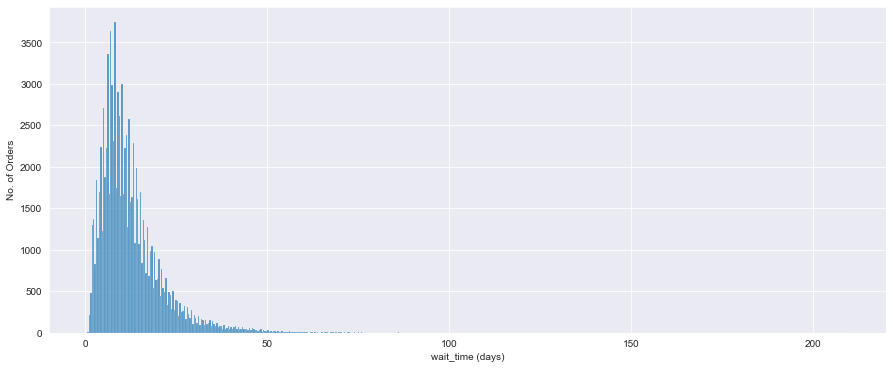

In [5]:
# 'wait_time' histogram
sns.set_style('darkgrid')
plt.figure(figsize=(15,6))
sns.histplot(orders.wait_time)
plt.xlabel('wait_time (days)')
plt.ylabel('No. of Orders');

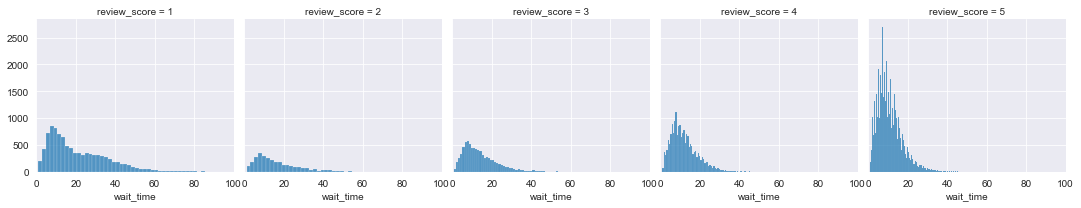

In [6]:
# Distribution of 'wait_time' by review_score
g = sns.FacetGrid(data=orders, col='review_score', )
g.map(sns.histplot, 'wait_time')
g.set(xlim=(0,100))
plt.show();

If we look at the change in shape of the `wait_time` distribution across the various review scores, we can see that the **lower** the score, the **flatter and more right-skewed** the shape becomes. This suggests that lower scores are more likely to be associated with a longer `wait_time` for their order deliveries. 

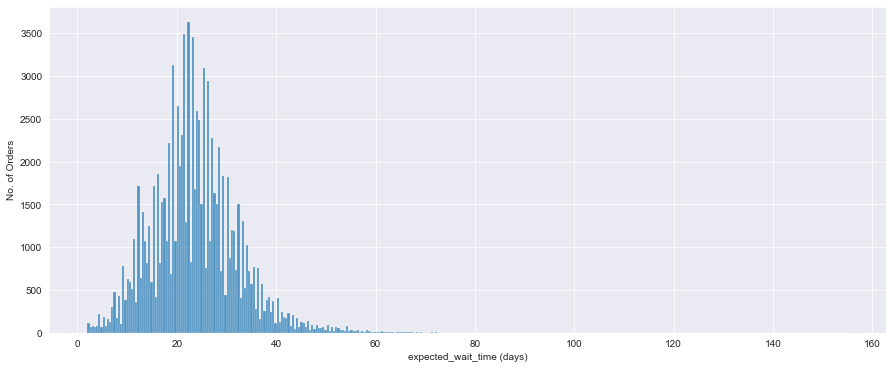

In [7]:
# 'expected_wait_time' histogram
plt.figure(figsize=(15,6))
sns.histplot(orders.expected_wait_time)
plt.xlabel('expected_wait_time (days)')
plt.ylabel('No. of Orders');


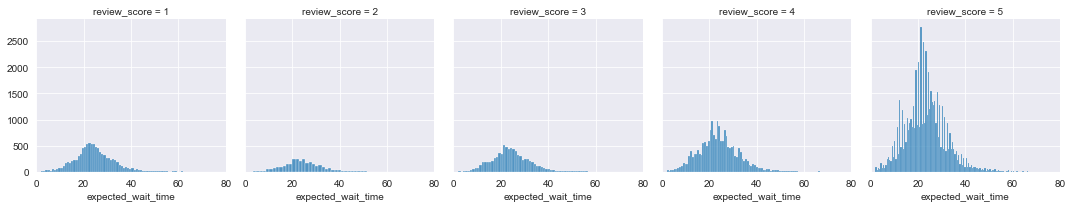

In [8]:
# Distribution of 'expected_wait_time' by review score
g1 = sns.FacetGrid(data=orders, col='review_score')
g1.set(xlim=(0,80))
g1.map(sns.histplot, 'expected_wait_time');

With `expected_wait_time`, which represents *how much time a customer has been told to wait before delivery of his or her order*, we see a roughly symmetrical distribution with **average time of ~23 days** across all review scores. While we clearly see *higher peaks with the higher review scores* of 4 and 5, the *heights of the peaks for the lower scores are less pronounced*. We'll check later in our analysis if differences in peaks are just a reflection of the underlying distribution of `review_score` in the data (and not necessarily associated with `expected_wait_time`).  





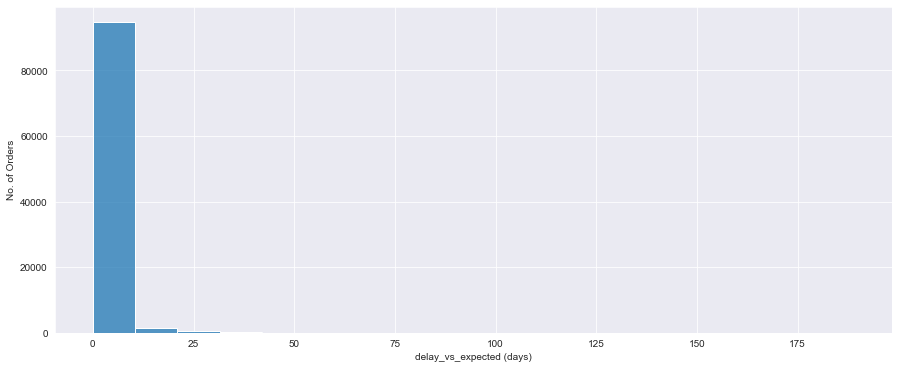

In [9]:
# 'delay_vs_expected' histogram
plt.figure(figsize=(15,6))

sns.histplot(orders.delay_vs_expected)
plt.xlabel('delay_vs_expected (days)')
plt.ylabel('No. of Orders');

From this distribution, it's clear that the vast majority of orders do not arrive after their expected delivery date. In fact, *delayed orders* make up only a tiny fraction of all orders. 

In [10]:
# Number of delayed orders
orders[orders.delay_vs_expected > 0].shape[0]

7865

In [11]:
# Number of delayed orders and receiving review score of 1
orders[(orders.delay_vs_expected > 0) & (orders.review_score == 1)].shape[0] 

3671

Out of **97,000** orders, only about **8%** (7,865 orders) were delayed. And, out of those that got delayed, **about half** (3,671 orders) received **`review_score` = 1**.

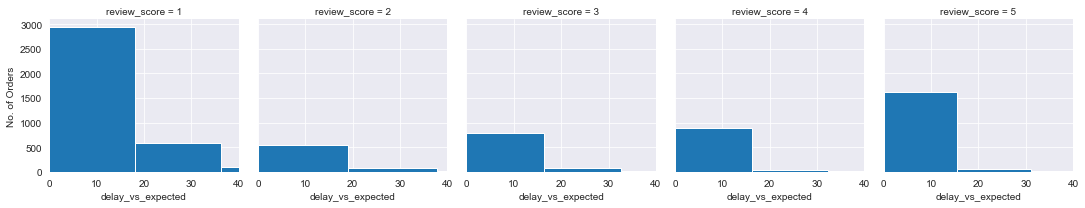

In [12]:
# Orders that were delayed 
orders_delayed = orders[orders.delay_vs_expected>0]

# Distribution of delayed orders by 'reveiw_score'
g2 = sns.FacetGrid(data=orders_delayed, col='review_score')
g2.set(xlim=(0,40))
g2.map(plt.hist, 'delay_vs_expected')
g2.axes[0,0].set_ylabel('No. of Orders');

If we look at the `delay_vs_expected` distribution by `review_score`, orders with *longer delays make up a larger proportion of those with lower review scores.*


### 3.2.2. Distributions for `review_score`, `dim_is_one_star` , and `dim_is_five_star` <a id=distributions-review-score></a>

This grouping represents the target variables in our analysis. The variables `dim_is_one_star` and `dim_is_five_star` are one-hot encodings for a `review_score` with *one star* and *five stars*, respectively.

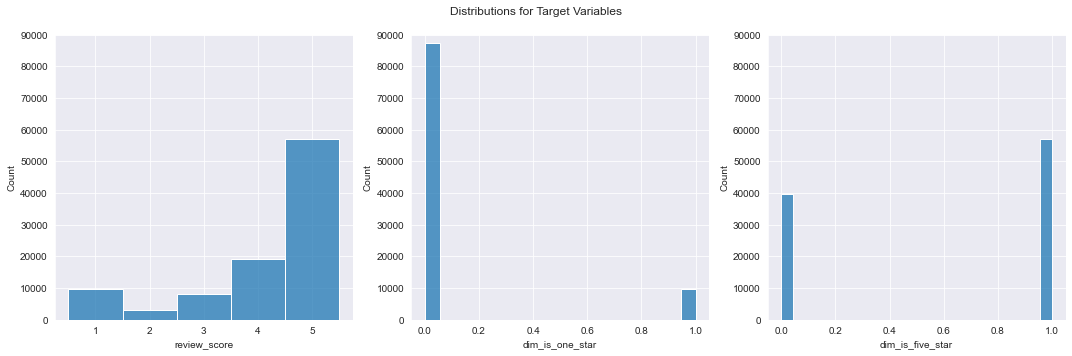

In [13]:
# Histograms of 'review_score', 'dim_is_one_star', and 'dim_is_five_star' 
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Distributions for Target Variables')

ax1 = sns.histplot(orders.review_score, discrete=True, ax=ax1)
ax1.set_ylim(0, 90000);

ax2 = sns.histplot(orders.dim_is_one_star, ax=ax2);
ax2.set_ylim(0, 90000);

ax3 = sns.histplot(orders.dim_is_five_star, ax=ax3)
ax3.set_ylim(0, 90000);

plt.tight_layout();

In [14]:
# Distribution of 'review_score' (%)
pd.DataFrame(orders.review_score.value_counts().sort_index(ascending=False)/len(orders)*100)

,review_score
5,58.906058
4,19.627450
3,8.304555
2,3.108023
1,10.053914


With this distribution of `review_score`, we can see a similar pattern that was reflected in the peak heights of the the first grouping of features `wait_time`, `expected_wait_time`, and `delay_vs_expected`. Namely, the lowest point is at score 2, followed by similar heights for 1 and 3, followed by a higher level for score 4, and then finally a significantly higher level for score 5 (Scores with **5 stars** make up **58.9%** of all reviews).  

This reflects a **J-shaped distribution** which is a common phenomenon among online reviews. Possible explanations for this include:

- **under-reporting bias** - customers who have no strong views either way are less likely to respond, leaving a dip in the area of 'average' ratings.
- **purchasing bias** - customers who have already purchased the product are already positively predisposed, leading to a disproportionate number of positive ratings.
- **social influence bias** - customers can be influenced by existing reviews they've seen, magnifying the effect of over-reporting highly positive or highly critical ratings.

Having this J-shaped distribution would suggest that for the features `expected_wait_time` and `delay_vs_expected`, the differences in peak height can be primarily attributed to the distribution of `review_score` in the dataset. However, with the `wait_time` feature, the *additional differences in skewness* suggest that there is a an additional relationship with the target variable `review_score` that is not fully explained by the underlying distribution.

### 3.2.3. Distributions for `number_of_products`, `number_of_sellers`, `price`, and `freight_value` <a id=distributions-number-of-products></a>

This grouping of features focus more on the characteristics of the order itself. 

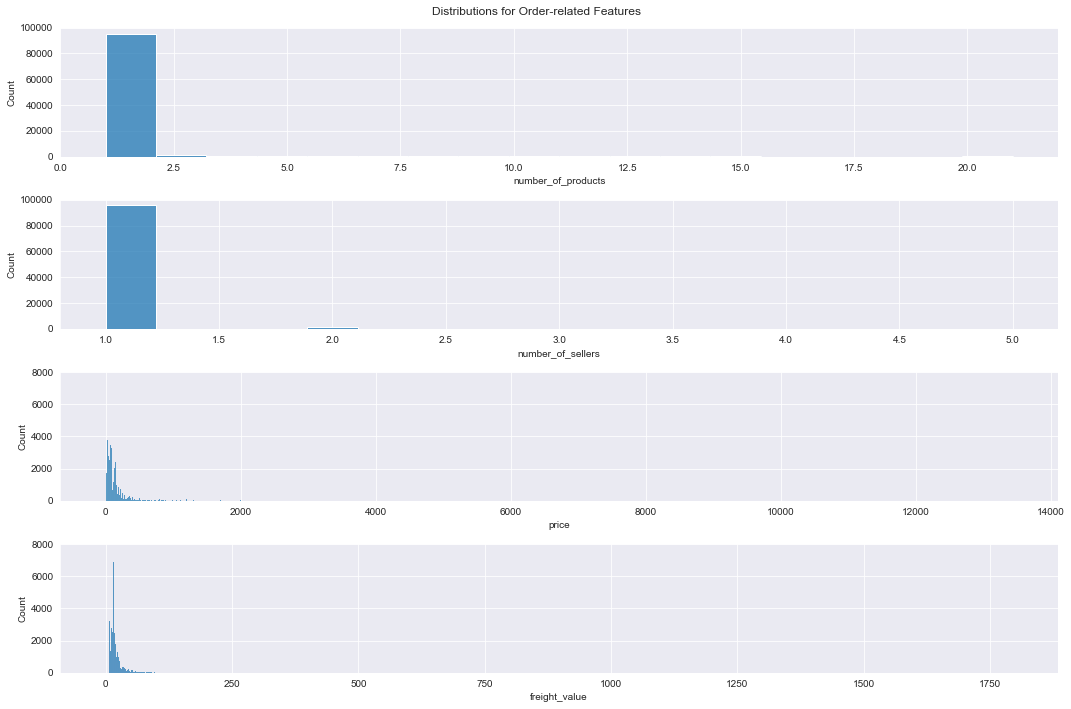

In [15]:
# Histograms for 'number_of_products','number_of_sellers','price', and 'freight_value'
fig, (ax1,ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15, 10))
fig.suptitle('Distributions for Order-related Features')

ax1 = sns.histplot(orders.number_of_products, ax=ax1)
ax1.set_ylim(0,100000);

ax2 = sns.histplot(orders.number_of_sellers, ax=ax2)
ax2.set_ylim(0,100000);

ax3 = sns.histplot(orders.price, ax=ax3);
ax3.set_ylim(0,8000);

ax4 = sns.histplot(orders.freight_value, ax=ax4);
ax4.set_ylim(0,8000);

fig.tight_layout()

From these histograms it's clear that there are some pretty large outliers making these plots difficult to read. 

Let's look at the statistical summary to get a more precise picture.

In [16]:
orders[['number_of_products', 'number_of_sellers', 'price', 'freight_value']].describe()

,number_of_products,number_of_sellers,price,freight_value
count,97007.000000,97007.000000,97007.000000,97007.000000
mean,1.142598,1.013968,136.895781,22.780658
std,0.540014,0.123772,208.701803,21.532648
min,1.000000,1.000000,0.850000,0.000000
25%,1.000000,1.000000,45.900000,13.850000
50%,1.000000,1.000000,86.000000,17.170000
75%,1.000000,1.000000,149.900000,24.020000
max,21.000000,5.000000,13440.000000,1794.960000


With the stats panel and plots, it's clear that few orders contain more than one product or seller. 

In [17]:
# Number of orders with more than 1 product or 1 seller. Note that if an order has more than 1 seller, 
# it will by definition have more than 1 product.  
orders[orders.number_of_products > 1].shape[0]

9709

With about **97,000** orders, we see that about **10%** have more than one product or seller.

And, if we look at the **middle 50%** of all orders, the *order value* is in the range of **45-150 BRL** (10-30 USD), and *shipping costs* fall in the range of **14-24 BRL** (3-5 USD). 

Evidently, most orders are relatively small in both *order size* and *value*.  

## 3.3. Correlations <a id=correlations></a>

Let's look to see if there are correlations between features in the **Orders** dataset.

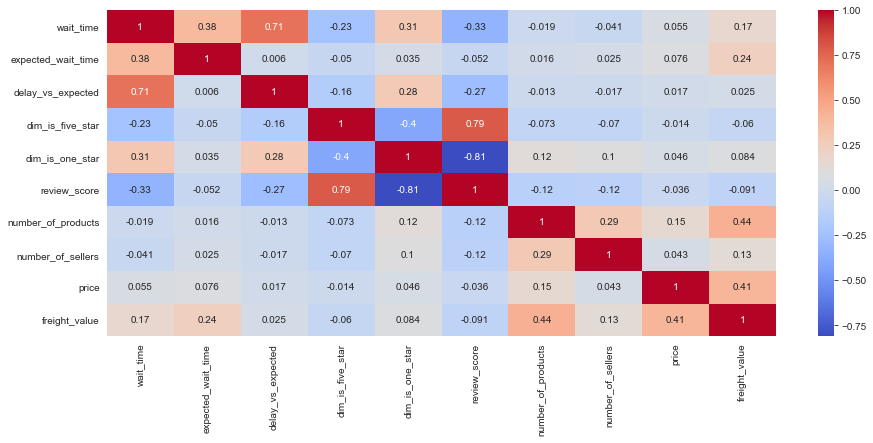

In [18]:
# Use heatmap to see correlations between features and target variables
plt.figure(figsize=(15,6))
sns.heatmap(orders.corr(), cmap='coolwarm', annot=True);

In [19]:
# Isolated view of correlation coefficients with target variable `review_score`
orders.corr()['review_score'].sort_values(ascending=False)

review_score          1.000000
dim_is_five_star      0.792079
price                -0.036006
expected_wait_time   -0.052191
freight_value        -0.091023
number_of_sellers    -0.116317
number_of_products   -0.124405
delay_vs_expected    -0.271885
wait_time            -0.334806
dim_is_one_star      -0.810262
Name: review_score, dtype: float64

Among features `wait_time` and `delay_vs_expected` appear to have the strongest correlation with the target variable `review_score`. However, we also see that both features (`wait_time` and `delay_vs_expected`) are highly correlated with each other (r = 0.71).

Since features that are highly correlated may be concealing a confounding variable and lead to unreliable coefficients and p-values in a regression model, we may need to drop one of these features later.  

## 3.4. Univariate Regression <a id=univariate-regression></a>

Based on our inspection of correlation coefficients, we see that the features `wait_time` (r = 0.33) and `delay_vs_expected` (r = 0.27) have a stronger correlation with `review_score` than other features, so let's first look at them individually by running simple univariate regressions.

### 3.4.1. Simple regression of `review_score` against `wait_time` <a id=regression-wait-time></a>

In [20]:
formula = 'review_score ~ wait_time'
model1 = smf.ols(formula=formula, data=orders).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                 1.225e+04
Date:                Tue, 22 Mar 2022   Prob (F-statistic):               0.00
Time:                        10:30:05   Log-Likelihood:            -1.5707e+05
No. Observations:               97007   AIC:                         3.142e+05
Df Residuals:                   97005   BIC:                         3.142e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7138      0.006    726.803      0.000       4.701       4.727
wait_time     -0.0455      0.000   -110.664      0.000      -0.046      -0.045
==============================================================================
Omnibus:                    19241.637   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34157.401
Skew:                          -1.282   Prob(JB):                         0.00
Kurtosis:                       4.371   Cond. No.                         26.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation of Results**

For every additional day of `wait_time`, we can say with a 95% confidence level that the `review_score` is **lower by 4.6%** on average (slope = -0.046). This suggests that there is an association between a longer `wait_time` and a lower `review_score`. 

- With a **p-value** close to zero, our coefficient for `wait_time` is **statistically significant**. 
- The **R-squared** indicates that **11% of the variance** found in the `review_score` is attributable to `wait_time`.
- Since within the **95% confidence interval** the slope does not contain the value zero, we can accept the **coefficient as reliable**.

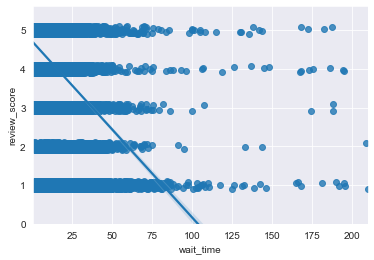

In [21]:
# Plot the univariate regression of 'review_score' on 'wait_time'
sns.regplot(x=orders.wait_time, y=orders.review_score, y_jitter=0.1)
plt.ylim(bottom=0);

### 3.4.2. Simple regression of `review_score` against `delay_vs_expected` <a id=regression-delay-vs-expected></a>

In [22]:
formula = 'review_score ~ delay_vs_expected'
model2 = smf.ols(formula=formula, data=orders).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     7743.
Date:                Tue, 22 Mar 2022   Prob (F-statistic):               0.00
Time:                        10:30:15   Log-Likelihood:            -1.5912e+05
No. Observations:               97007   AIC:                         3.182e+05
Df Residuals:                   97005   BIC:                         3.183e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.1997      0.004   1034.674      0.000       4.192       4.208
delay_vs_expected    -0.0742      0.001    -87.995      0.000      -0.076      -0.073
==============================================================================
Omnibus:                    20264.119   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46233.422
Skew:                          -1.191   Prob(JB):                         0.00
Kurtosis:                       5.401   Cond. No.                         4.88
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation of Results**

For each additional day of **delay** that the customer waits **beyond the expected delivery date**, we can say with a 95% confidence level that the `review_score` is **lower by 7.4%** on average (slope = -0.074). This suggests that there is an association between *delays* in delivery and a *lower* `review_score`.   

- With a **p-value** close to zero, the coefficient for `delay_vs_expected` is **statistically significant**.
- The **R-squared** indicates that **7% of the variance** found in the `review_score` is attributable to `delay_vs_expected`.
- Since within the **95% confidence interval** the slope does not contain the value zero, we can accept the **coefficient as reliable**.

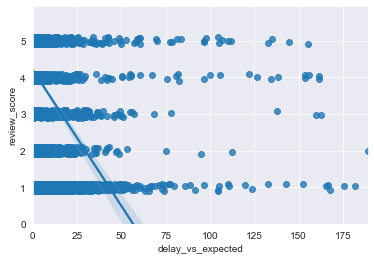

In [23]:
# Plot the univariate regression of 'review_score' on 'delay_vs_expected'
sns.regplot(x=orders.delay_vs_expected, y=orders.review_score, y_jitter=0.1)
plt.ylim(bottom=0);

## 3.5. Multivariate Regression <a id=multivariate-regression></a>

Let's now build multivariate regression models so that we can incorporate several features at once. We'll start with a bivariate model with `wait_time` and `delay_vs_expected`. 

### 3.5.1. Bivariate Regression Model <a id=bivariate-regression-model></a>
First, we'll regress `review_score` on just the two features `wait_time` and `delay_vs_expected`.

In [24]:
model3 = smf.ols('review_score ~ wait_time + delay_vs_expected', data=orders).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     6275.
Date:                Tue, 22 Mar 2022   Prob (F-statistic):               0.00
Time:                        10:30:28   Log-Likelihood:            -1.5694e+05
No. Observations:               97007   AIC:                         3.139e+05
Df Residuals:                   97004   BIC:                         3.139e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.6440      0.008    599.083      0.000       4.629       4.659
wait_time            -0.0388      0.001    -66.715      0.000      -0.040      -0.038
delay_vs_expected    -0.0191      0.001    -16.399      0.000      -0.021      -0.017
==============================================================================
Omnibus:                    19637.196   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38268.583
Skew:                          -1.235   Prob(JB):                         0.00
Kurtosis:                       4.834   Cond. No.                         31.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation of Results**

While holding `delay_vs_expected` constant, each additional day of **`wait_time`** reduces the `review_score` by **3.9%** on average (slope = -0.0388). 

While holding `wait_time` constant, each additional day of **`delay_vs_expected`** reduces the `review_score` by **1.9%** on average (slope = -0.0191).

Therefore, in contrast to our *univariate analysis*, which suggested **`delay_vs_expected`** (**-7.4%**) has a stronger association with a low `review_score` than **`wait_time`** (**-4.6%**), we find the opposite to be the case in our bivariate analysis.

With our *bivariate regression model* that considers both features, the **`wait_time`** (**-3.9%**) has a stronger association with a low `review_score` than **`delay_vs_expected`** (**-1.9%**).

- Both features show **p-values** close to zero indicating that they are **statistically significant**
- Within the **95% confidence interval**, slopes for the **partial coefficients** do not contain zero which allows us to consider them **reliable**
- **R-squared** is relatively low: only **11.5%** of the variation in `review_score` is explained by the variation of `wait_time` and `delay_vs_expected`

### 3.5.2. Multivariate Regression Model <a id=multivariate-regression-model></a>

In this next model we'll add other features from our data to build a more complete picture of which factors impact the `review_score`. Since the **R-squared** in our previous model with only two features was relatively low, perhaps we'll see an improvement here. 

In [25]:
# Features to include in the multivariate model
features = [
    'wait_time',
    'delay_vs_expected',
    'number_of_products',
    'number_of_sellers',
    'price',
    'freight_value']

#### 3.5.2.1. Feature Scaling <a id=feature-scaling></a>

Because these features are in different units, we'll standardize them first before putting them into our regression model. 

In [26]:
# Standardize features by calculating respective z-scores: Z = (X - mu) / sigma

orders_standardized = orders.copy()
for f in features:
    mu = orders[f].mean()
    sigma = orders[f].std()
    orders_standardized[f] = orders[f].map(lambda x: (x - mu) / sigma)

orders_standardized.head()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,-0.432597,15.544063,-0.16311,delivered,0,0,4,-0.264063,-0.112854,-0.512242,-0.652992
1,53cdb2fc8bc7dce0b6741e2150273451,0.127585,19.137766,-0.16311,delivered,0,0,4,-0.264063,-0.112854,-0.087186,-0.000959
2,47770eb9100c2d0c44946d9cf07ec65d,-0.332241,26.639711,-0.16311,delivered,1,0,5,-0.264063,-0.112854,0.110225,-0.165361
3,949d5b44dbf5de918fe9c16f97b45f8a,0.067507,26.188819,-0.16311,delivered,1,0,5,-0.264063,-0.112854,-0.440321,0.205239
4,ad21c59c0840e6cb83a9ceb5573f8159,-1.015545,12.112049,-0.16311,delivered,1,0,5,-0.264063,-0.112854,-0.560588,-0.652992


#### 3.5.2.2. Build Model <a id=build-model></a>

In [27]:
# Model4; create formula for stats.model
formula = 'review_score ~ ' + ' + ' .join(features)
formula

'review_score ~ wait_time + delay_vs_expected + number_of_products + number_of_sellers + price + freight_value'

In [28]:
model4 = smf.ols(formula = formula, data = orders_standardized).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     2661.
Date:                Tue, 22 Mar 2022   Prob (F-statistic):               0.00
Time:                        10:30:30   Log-Likelihood:            -1.5545e+05
No. Observations:               97007   AIC:                         3.109e+05
Df Residuals:                   97000   BIC:                         3.110e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.1422      0.004   1073.800      0.000       4.135       4.150
wait_time             -0.3898      0.006    -69.175      0.000      -0.401      -0.379
delay_vs_expected     -0.0816      0.006    -14.772      0.000      -0.092      -0.071
number_of_products    -0.1465      0.004    -32.751      0.000      -0.155      -0.138
number_of_sellers     -0.1305      0.004    -32.377      0.000      -0.138      -0.123
price                 -0.0099      0.004     -2.339      0.019      -0.018      -0.002
freight_value          0.0350      0.005      7.301      0.000       0.026       0.044
==============================================================================
Omnibus:                    18510.939   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36369.606
Skew:                          -1.162   Prob(JB):                         0.00
Kurtosis:                       4.897   Cond. No.                         2.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

To more easily compare the various partial coefficents of the features, we'll plot them on a bar chart.

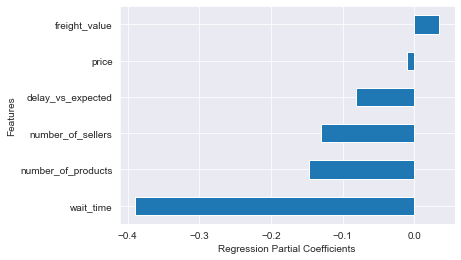

In [29]:
# Regression Partial Coefficients Bar Chart
model4.params[1:].sort_values().plot(kind='barh')
plt.xlabel('Regression Partial Coefficients')
plt.ylabel('Features');

**Interpretation of Results**

With our new regression model which includes other features from our dataset, the **`wait_time`** variable (slope = -0.39) has the most explanatory power for `review_score` relative to the other features. 

The difference between the coefficients for `wait_time` and `delay_vs_expected` has also widened considerably compared to our previous regression models. 

Additionally, with this new model, we can see that an increase in `number_of_sellers` (slope = -0.13) or `number_of_products` (slope = -0.15) within an order leads to a decrease in `review_score`.

- The **R-squared** for this new model has **increased only slightly** and still only explains about **14.1%** of the variance in the `review_score`. This suggests *most factors impacting the review score lie outside of the orders dataset.*
- The **p-values** for our partial coefficients are mostly close to zero. However, the **coefficient** for `price` is **small relative to its standard error**, and the **95% confidence interval** is **close to containing the value of zero, which would make the coefficient less reliable**.

### 3.5.3. Multicollinearity Check with VIF <a id=multicollinearity-vif></a>

We'll stick with the same set of features from our last multivariate regression model, but first let's confirm if we have any additional issues with multicollinearity by looking at the **variance inflation factor (VIF)**. Generally speaking, a value under 10 should be acceptable.

$ VIF = \frac {1}{1 - R^2} $

In [30]:
# Check for multicollinearity by looking at variance inflation factor (VIF)
features = ['wait_time', 'delay_vs_expected', 'number_of_products', 'number_of_sellers', 'price', 'freight_value']

X = orders[features]
X.head()

,wait_time,delay_vs_expected,number_of_products,number_of_sellers,price,freight_value
0,8.436574,0.0,1,1,29.99,8.72
1,13.782037,0.0,1,1,118.70,22.76
2,9.394213,0.0,1,1,159.90,19.22
3,13.208750,0.0,1,1,45.00,27.20
4,2.873877,0.0,1,1,19.90,8.72


In [31]:
df = pd.DataFrame()
df['VIF'] = [vif(X.values, i) for i in range(X.shape[1])]
df['Features'] = X.columns
df

,VIF,Features
0,5.482640,wait_time
1,2.057560,delay_vs_expected
2,7.363534,number_of_products
3,8.910229,number_of_sellers
4,1.721790,price
5,3.265091,freight_value


Since all of our features still come in below our acceptable threshold of 10 for VIF, we'll keep this feature set. 

### 3.5.4. Multivariate Regression Model after Feature Selection <a id=multivariate-after-feature-selection></a>

After removing some features due to multicollinearity, let's re-run our linear regression model.

In [32]:
# Model 5 - New features list after handling multicollinearity
features2 = ['wait_time', 'delay_vs_expected', 'number_of_products', 'number_of_sellers', 'freight_value']
formula = 'review_score ~ ' + ' + ' .join(features2)
model5 = smf.ols(formula = formula, data = orders_standardized).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     3192.
Date:                Tue, 22 Mar 2022   Prob (F-statistic):               0.00
Time:                        10:30:31   Log-Likelihood:            -1.5545e+05
No. Observations:               97007   AIC:                         3.109e+05
Df Residuals:                   97001   BIC:                         3.110e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.1422      0.004   1073.775      0.000       4.135       4.150
wait_time             -0.3894      0.006    -69.134      0.000      -0.400      -0.378
delay_vs_expected     -0.0820      0.006    -14.844      0.000      -0.093      -0.071
number_of_products    -0.1461      0.004    -32.689      0.000      -0.155      -0.137
number_of_sellers     -0.1304      0.004    -32.363      0.000      -0.138      -0.123
freight_value          0.0307      0.004      6.934      0.000       0.022       0.039
==============================================================================
Omnibus:                    18518.775   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36400.290
Skew:                          -1.162   Prob(JB):                         0.00
Kurtosis:                       4.899   Cond. No.                         2.55
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our new model's **R-squared** is still **14%**, and the coefficients for our features *have not changed much* indicating that with our new slimmed down model, we're able to achieve a similar level of explanatory power!

 ### 3.5.5. Residuals <a id=residuals></a>

Besides checking the statistical significance of our feature coefficients and the R-squared of our model, we can evaluate the performance of our regression model by looking at the **residuals** (predicted values - real values). More specifically, we can calculate the **Root Mean Square Error (RMSE)** as a gauge of how much on average our regression model is predicting scores that differ from the real scores.     

In [33]:
# Calculate residuals (predicted values - real values)
predicted_review_score = model5.predict(orders_standardized[features])
residuals = predicted_review_score - orders_standardized.review_score
residuals.head()

0    0.357296
1    0.159207
2   -0.666797
3   -0.811064
4   -0.415714
dtype: float64

In [34]:
# Calculate the RMSE 
RMSE = (residuals.map(lambda x: x**2).sum() / len(residuals))**0.5
RMSE

1.2014612515439624

Here the **RMSE** tells us that on average our predicted scores are about **1.2** stars off of the real scores. On a 5-star rating system, that's not great, but it's not horrible either. 

Let's further evaluate our residuals by creating a density plot.

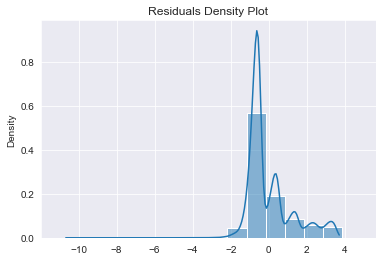

In [35]:
# Create density plot of residuals
sns.histplot(residuals, kde=True, stat='density', discrete=True)
plt.title('Residuals Density Plot');

Our residuals plot has an odd shape, partly because our model with our current set of features still lacks explanatory power (low R-Squared), and also because we are using a linear regression model, which treats our target variable as continuous. However, perhaps it would be better to treat our target variable as a categorical variable that is discrete. Let's model our data using a logistic regression!

## 3.6. Logistic Regression <a id=logistic-regression></a>

Rather than use a linear regression to predict the full range of `review_score`, let's instead use a logistic regression model to focus on what features lead to getting either the worst score (`dim_is_one_star`) or the best score (`dim_is_five_star`). 

### 3.6.1. Logistic Regression | 1-Star Review Model <a id=logistic-1-star></a>

In [36]:
# Fit logit model for 1-star reviews
logit_one = smf.logit(formula='dim_is_one_star ~' + ' + '.join(features), data=orders_standardized).fit()
logit_one.summary()

Optimization terminated successfully.
         Current function value: 0.280352
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        dim_is_one_star   No. Observations:                97007
Model:                          Logit   Df Residuals:                    97000
Method:                           MLE   Df Model:                            6
Date:                Tue, 22 Mar 2022   Pseudo R-squ.:                  0.1407
Time:                        10:30:32   Log-Likelihood:                -27196.
converged:                       True   LL-Null:                       -31650.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -2.4222      0.013   -192.272      0.000      -2.447      -2.398
wait_time              0.6184      0.015     40.920      0.000       0.589       0.648
delay_vs_expected      0.3167      0.018     17.660      0.000       0.282       0.352
number_of_products     0.2740      0.011     25.910      0.000       0.253       0.295
number_of_sellers      0.1747      0.008     22.524      0.000       0.159       0.190
price                  0.0627      0.011      5.684      0.000       0.041       0.084
freight_value         -0.0718      0.014     -5.308      0.000      -0.098      -0.045
======================================================================================
"""

In order to interpret our coefficients from our logistic regression, we'll first need to convert them from *log-odds (logits)* to *odds*. 

In [37]:
# Log-odds to odds conversion by exponentiating
logit_one_results = pd.DataFrame(logit_one.params, columns=['log-odds'])
logit_one_results['odds'] = logit_one_results['log-odds'].apply(lambda x: math.exp(x))
logit_one_results

,log-odds,odds
Intercept,-2.422221,0.088724
wait_time,0.618378,1.855916
delay_vs_expected,0.316696,1.372585
number_of_products,0.274001,1.315216
number_of_sellers,0.174681,1.190866
price,0.062704,1.064712
freight_value,-0.071762,0.930752


After conversion to *odds*, we should now be able to interpret the coefficient for each feature as ***the change in odds*** for every additional unit of that feature. 

Note that when interpreting odds, **1.0** is in the middle of the scale, while values **greater than 1** represent an ***increase*** in odds, and values **less than 1** represent a ***decrease*** in odds. Values at **1.0** are also said to have a ***50/50 chance*** or **1:1 odds** (i.e., effectively, ***there is no impact on the outcome***).     

**Interpretation of Results**

- Given our logistic regression, we can say that holding all other variables constant, *for each additional day of `wait_time`, the odds of getting a 1-star **increases** on average by **85%**.* 

- Similar to what we saw in our linear regression models, `delay_vs_expected` has less influence compared to `wait_time`. *For each additional day of `delay_vs_expected`, the odds of getting a 1-star **increases** on average by only **37%**.*

- Also, like our linear regression model, the feature importance of `number_of_products` and `number_of_sellers` align. *For every additional **product** or **seller** included in an order, on average, the odds of getting a 1-star review **increases** by **32%** and **19%**, respectively.* 

- From our logistic regression, `price` has a small effect of ***increasing*** odds by only **6%** for each additional Brazilian Real (BRL).

- And, `freight_value` interestingly slightly moves in the opposite direction. With each additional Brazilian Real (BRL in `freight_value` the odds of getting a 1-star review on average ***decrease*** by **7%**.

### 3.6.2. Logistic Regression | 5-Star Review Model <a id=logistic-5-star></a>

Now, let's check out our logit model for 5-star reviews.

In [38]:
# Fit logit model for 5-star reviews
logit_five = smf.logit(formula='dim_is_five_star ~' + ' + '.join(features), data=orders_standardized).fit()
logit_five.summary()

Optimization terminated successfully.
         Current function value: 0.638115
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       dim_is_five_star   No. Observations:                97007
Model:                          Logit   Df Residuals:                    97000
Method:                           MLE   Df Model:                            6
Date:                Tue, 22 Mar 2022   Pseudo R-squ.:                 0.05771
Time:                        10:30:33   Log-Likelihood:                -61902.
converged:                       True   LL-Null:                       -65693.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3231      0.007     45.355      0.000       0.309       0.337
wait_time             -0.4718      0.010    -45.267      0.000      -0.492      -0.451
delay_vs_expected     -0.4830      0.023    -20.746      0.000      -0.529      -0.437
number_of_products    -0.1533      0.008    -18.383      0.000      -0.170      -0.137
number_of_sellers     -0.1413      0.008    -18.123      0.000      -0.157      -0.126
price                  0.0135      0.008      1.778      0.075      -0.001       0.028
freight_value          0.0341      0.009      3.878      0.000       0.017       0.051
======================================================================================
"""

In [39]:
# Log-odds to odds conversion by exponentiating
logit_five_results = pd.DataFrame(logit_five.params, columns=['log-odds'])
logit_five_results['odds'] = logit_five_results['log-odds'].apply(lambda x: math.exp(x))
logit_five_results

,log-odds,odds
Intercept,0.323106,1.381412
wait_time,-0.471834,0.623857
delay_vs_expected,-0.482999,0.616930
number_of_products,-0.153298,0.857874
number_of_sellers,-0.141264,0.868260
price,0.013481,1.013573
freight_value,0.034097,1.034685


**Interpretation of Results**
- With our **logit_five_model**, we see that `delay_vs_expected` becomes as influential in losing a 5-star rating as `wait_time`. *Holding all other variables constant, for each additional day in **delay** or **wait time**, the odds of getting 5 stars **decrease** on average by **38%**.*   

- Also, we see that the features `number_of_products` and `number_of_products` have similar impact on losing a 5-star rating. *Holding all other variables constant, for each additional **product** or **seller** put in an order, the odds of getting 5 stars **decrease** on average by **14%** and **13%**, respectively.*

- For `price` and `freight_value` on average there is a slight **increase** in odds of getting 5 stars, **1%** and **3%**, respectively. 

### 3.6.3. Logistic Regression Model Comparison <a id=model-comparison></a>

To more easily compare the direction and magnitude of differences of our two logit models, let's plot the coefficients for each logit model side-by-side.

/Users/atat/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


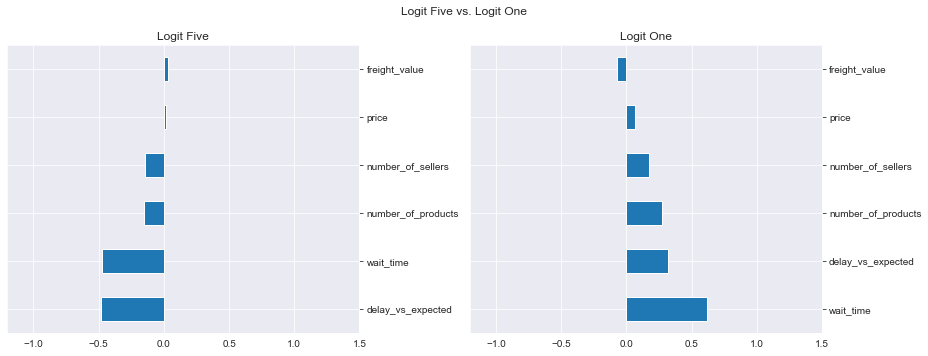

In [40]:
# Logistic Regression Model Comparison
fig = plt.figure(figsize=(13,5))
fig.suptitle('Logit Five vs. Logit One')

# Logistic Regression - logit_five_model
ax1 = plt.subplot(1,2,1)
ax1.set_title('Logit Five')
ax1.yaxis.tick_right()
ax1.set_xlim(-1.2, 1.5)
logit_five.params[1:].sort_values().plot(kind='barh', ax=ax1)

# Logistic Regression - logit_one_model
ax2 = plt.subplot(1,2,2)
ax2.set_title('Logit One')
ax2.yaxis.tick_right()
ax2.set_xlim(-1.2, 1.5)
logit_one.params[1:].sort_values(ascending=False).plot(kind='barh', ax=ax2)

fig.tight_layout()
plt.show();

In [41]:
logit_five_results = pd.DataFrame(logit_five.params, columns=['log-odds'])
logit_five_results['odds'] = logit_five_results['log-odds'].apply(lambda x: math.exp(x))
logit_five_results

,log-odds,odds
Intercept,0.323106,1.381412
wait_time,-0.471834,0.623857
delay_vs_expected,-0.482999,0.616930
number_of_products,-0.153298,0.857874
number_of_sellers,-0.141264,0.868260
price,0.013481,1.013573
freight_value,0.034097,1.034685


In [42]:
logit_five = smf.logit(formula='dim_is_five_star ~' + ' + '.join(features), data=orders_standardized).fit()
logit_five.summary()

Optimization terminated successfully.
         Current function value: 0.638115
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       dim_is_five_star   No. Observations:                97007
Model:                          Logit   Df Residuals:                    97000
Method:                           MLE   Df Model:                            6
Date:                Tue, 22 Mar 2022   Pseudo R-squ.:                 0.05771
Time:                        10:30:34   Log-Likelihood:                -61902.
converged:                       True   LL-Null:                       -65693.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3231      0.007     45.355      0.000       0.309       0.337
wait_time             -0.4718      0.010    -45.267      0.000      -0.492      -0.451
delay_vs_expected     -0.4830      0.023    -20.746      0.000      -0.529      -0.437
number_of_products    -0.1533      0.008    -18.383      0.000      -0.170      -0.137
number_of_sellers     -0.1413      0.008    -18.123      0.000      -0.157      -0.126
price                  0.0135      0.008      1.778      0.075      -0.001       0.028
freight_value          0.0341      0.009      3.878      0.000       0.017       0.051
======================================================================================
"""

In [43]:
logit_five_results = pd.DataFrame(logit_five.params, columns=['log-odds'])
logit_five_results['odds'] = logit_five_results['log-odds'].apply(lambda x: math.exp(x))
logit_five_results

,log-odds,odds
Intercept,0.323106,1.381412
wait_time,-0.471834,0.623857
delay_vs_expected,-0.482999,0.616930
number_of_products,-0.153298,0.857874
number_of_sellers,-0.141264,0.868260
price,0.013481,1.013573
freight_value,0.034097,1.034685


In terms of feature importance, the two models align similarly. However, there were a few notable findings:

- An extra day of delay is more likely to result in losing a chance for getting 5 stars than getting a 1-star review. 
- Longer wait times appear to make more of a difference in getting a 1-star review than losing a chance at a 5 stars.
- The number of products and sellers in an order are less impactful than how long a customer has to wait for their order. However, adding an additional product seems to make slightly more of a difference than an additional seller.
- The price and shipping value for orders only have a low association with getting 1- or 5-star reviews. 

### 3.6.4. Linear vs Logistic Regression Coefficients <a id=regression-coefficients></a>

Let's also plot and compare the coefficients between our linear and logistic regression models. While the *values* of the coefficients are *not directly comparable*, we can check the *relative importance* of the features for each model. 

In [44]:
print(model4.summary())
print((('-----'*20) +'\n')*3)
print(logit_five.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     2661.
Date:                Tue, 22 Mar 2022   Prob (F-statistic):               0.00
Time:                        10:30:34   Log-Likelihood:            -1.5545e+05
No. Observations:               97007   AIC:                         3.109e+05
Df Residuals:                   97000   BIC:                         3.110e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.1422      0

/Users/atat/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


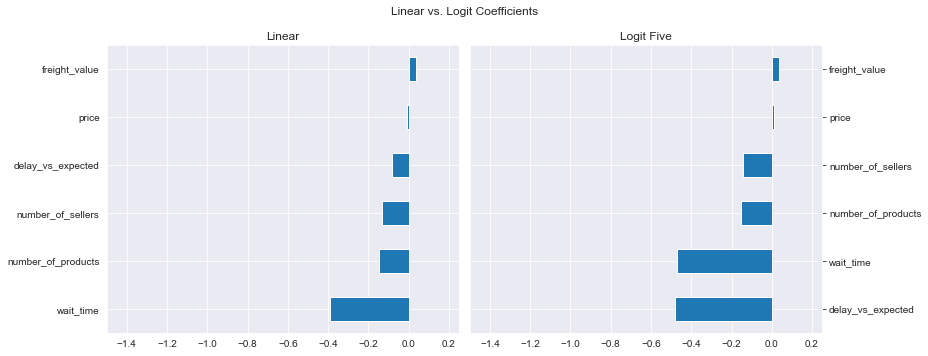

In [45]:
# Plot coefficients for comparison
fig = plt.figure(figsize=(13,5))
fig.suptitle('Linear vs. Logit Coefficients')

# Linear Regression - model4
ax1 = plt.subplot(1,2,1)
ax1.set_title('Linear')
ax1.set_xlim(-1.5, 0.25)
model4.params[1:].sort_values().plot(kind='barh', ax=ax1)

# Logistic Regression - logit_five_model
ax2 = plt.subplot(1,2,2)
ax2.set_title('Logit Five')
ax2.yaxis.tick_right()
ax2.set_xlim(-1.5, 0.25)
logit_five.params[1:].sort_values().plot(kind='barh', ax=ax2)

fig.tight_layout()
plt.show();

Our linear and logistic regression models in general show similar feature importance. One distinction appears to be the relative importance of `delay_vs_expected`. One possible explanation is that a delay would have more relative impact for the highest and lowest review scores, and less so for more mediocre reviews which are included as part of our linear regression model.  

***The analysis continues...***

We continue **Part 1** by analyzing the **Sellers Data** in this [notebook](https://nbviewer.org/github/phlln/olist-analysis/blob/main/notebooks/Sellers%20Data%20Analysis.ipynb?flush_cache=True).